In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,InputLayer, Conv2DTranspose, Dropout, BatchNormalization, Input, Concatenate, Activation, concatenate ,RepeatVector ,Reshape ,UpSampling2D
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import cv2
import PIL
from skimage import transform
from PIL import Image
import random
import h5py
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt


#  Loading the Data......



In [5]:
images_gray = np.load("drive/MyDrive/archive/l/gray_scale.npy")
images_ab1 = np.load("drive/MyDrive/archive/ab/ab/ab1.npy")
#images_ab2 = np.load("drive/MyDrive/archive/ab/ab/ab2.npy")
#images_ab3 = np.load("drive/MyDrive/archive/ab/ab/ab3.npy")

# Creating samples for training and testing  

(10000, 224, 224, 2)
3763200000
(25000, 224, 224, 3)


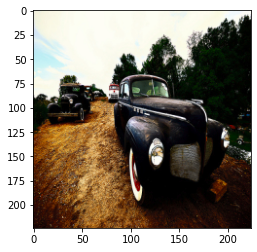

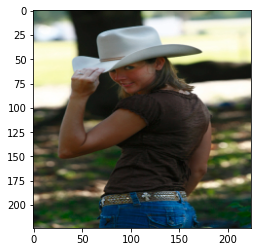

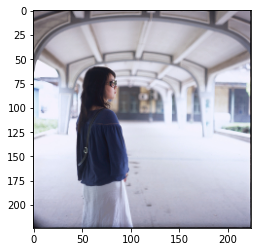

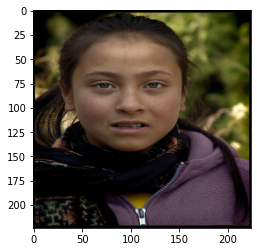

In [7]:
from skimage import io
import cv2
import matplotlib.pyplot as plt

def display(img):
    img = img.astype('uint8')
    plt.imshow(img,cmap='gray')
    plt.show()
    
    
paths =[images_ab1]

lsamples = images_gray

images = np.zeros((25000,224,224,3),dtype='uint8')
i = 0
for path in paths:
    ab_img = path
    images[i:i+ab_img.shape[0],:,:,0] = lsamples[i:i+ab_img.shape[0]]    
    images[i:i+ab_img.shape[0],:,:,1:] = ab_img
    i += ab_img.shape[0]
    print(ab_img.shape)
    
for i in range(25000):
    images[i] = cv2.cvtColor(images[i],cv2.COLOR_LAB2RGB)

print(np.size(images))
print(images.shape)
display(images[55])
display(images[1254])
display(images[2100])
display(images[2500])
del ab_img
del lsamples

In [ ]:
# making separate X set and Y set consisting of 12500 images
X = (images_gray[:200,:,:].astype('float')).reshape(200,224,224,1)
Y = (images_ab1[:200,:,:].astype('float'))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_val.shape)

(120, 224, 224, 1)
(120, 224, 224, 2)
(40, 224, 224, 1)
(40, 224, 224, 2)
(40, 224, 224, 1)
(40, 224, 224, 2)


# Loading pretrained Model ..... Inception-ResNet-v2

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('drive/MyDrive/archive/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
#To generate embeddings of 1000*1 by passing input images through InceptionResNetV2
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed
import tensorflow as tf

In [ ]:
#creating embeddings for Train data
incept_em = create_inception_embedding(X_train)
embeddings = RepeatVector(28 * 28)(incept_em)
layer_embedding_train = Reshape(([28, 28, 1000]))(embeddings)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



In [ ]:
print(layer_embedding_train.shape)

(120, 28, 28, 1000)


> > # THE MODEL

In [ ]:
model_path = "./color_model.h5"
checkpoint = ModelCheckpoint(model_path,
                            monitor = "val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose = 1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
#changes in model
from keras.regularizers import l2

#Encoder
embed_input = Input(shape=(28, 28, 1000))
encoder_input = Input(shape=(224, 224, 1,))
encoder_1 = Conv2D(64, (3,3), activation='relu', padding='same', strides=2, kernel_regularizer=l2(0.01))(encoder_input)
encoder_3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01), strides=2)(encoder_1)
encoder_5 = Conv2D(32, (3,3), activation='relu', padding='same', strides=2, kernel_regularizer=l2(0.01))(encoder_3)
encoder_6 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(encoder_5)
encoder_output= Conv2D(64, (3,3), activation='relu', padding='same')(encoder_6)
#Fusion layer
fusion_output = concatenate([encoder_output, embed_input], axis=3) 
fusion_output = Conv2D(64, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.01))(fusion_output)
#Decoder layer
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=[encoder_input,embed_input], outputs=decoder_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 112, 112, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_204 (Conv2D)            (None, 56, 56, 64)   36928       ['conv2d_203[0][0]']             
                                                                                              

In [ ]:
from keras.regularizers import l2

#Encoder
embed_input = Input(shape=(28, 28, 1000))
encoder_input = Input(shape=(224, 224, 1,))
encoder_1 = Conv2D(64, (3,3), activation='relu', padding='same', strides=2, kernel_regularizer=l2(0.01))(encoder_input)
encoder_2 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(encoder_1)
encoder_3 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01), strides=2)(encoder_2)
encoder_4 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(encoder_3)
encoder_5 = Conv2D(256, (3,3), activation='relu', padding='same', strides=2, kernel_regularizer=l2(0.01))(encoder_4)
encoder_6 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(encoder_5)
encoder_7 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(encoder_6)
encoder_output= Conv2D(256, (3,3), activation='relu', padding='same')(encoder_7)
#Fusion layer
fusion_output = concatenate([encoder_output, embed_input], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.01))(fusion_output)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.01))(fusion_output)
#Decoder layer
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=[encoder_input,embed_input], outputs=decoder_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 112, 112, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_204 (Conv2D)            (None, 112, 112, 12  73856       ['conv2d_203[0][0]']             
                                8)                                                            

# Training.....

In [ ]:
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
history = model.fit(x=[X_train,layer_embedding_train] ,y=y_train,callbacks = [checkpoint,es], batch_size=5, epochs=2500,steps_per_epoch=1)

Streaming output truncated to the last 5000 lines.
Epoch 1251/2500
1/1 [==============================] - 3s 3s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 99.1237 - acc: 0.7639
Epoch 1252/2500
1/1 [==============================] - 3s 3s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 101.4894 - acc: 0.7688
Epoch 1253/2500
1/1 [==============================] - 3s 3s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 105.7807 - acc: 0.8139
Epoch 1254/2500
1/1 [==============================] - 3s 3s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 107.9619 - acc: 0.6827
Epoch 1255/2500
1/1 [==============================] - 3s 3s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 116.9977 - acc: 0.7964
Epoch 1256/2500
1/1 [==============================] - 3s 3s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 103.0881 - acc: 0.6819
Epoch 1257/2500
1/1 [==============================] - 3s 3s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 99.7718 - acc: 0.7061
Epoch 1258/2500
1/1 [======

# Loss

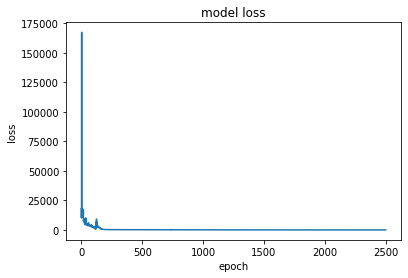

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Accuracy on training Data

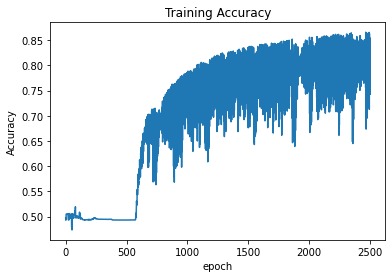

In [ ]:
plt.plot(history.history['acc'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.show()


# The prediction (results)

In [ ]:
print(X_val.shape)


(40, 224, 224, 1)


In [ ]:
# creating embeddings for val data
incept_em = create_inception_embedding(X_val)
embeddings = RepeatVector(28 * 28)(incept_em)
layer_embedding_val = Reshape(([28, 28, 1000]))(embeddings)

In [ ]:
print(X_val.shape)
print(layer_embedding_val.shape)

(40, 224, 224, 1)
(40, 28, 28, 1000)


In [ ]:
loss_val, acc_val = model.evaluate([X_val,layer_embedding_val] ,y_val,steps=3)
print()
print("Validation accuracy = ", acc_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.




Validation accuracy =  0.584938


In [ ]:
# creating embeddings for test data
incept_em = create_inception_embedding(X_test)
embeddings_test = RepeatVector(28 * 28)(incept_em)
layer_embedding_test = Reshape(([28, 28, 1000]))(embeddings_test)

In [ ]:
loss_test, acc_test = model.evaluate([X_test,layer_embedding_test] ,y_test,steps=3)
print()
print("Test accuracy = ", acc_test)


Test accuracy =  0.55964506


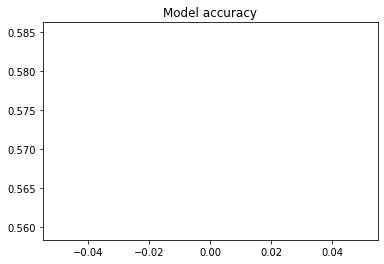

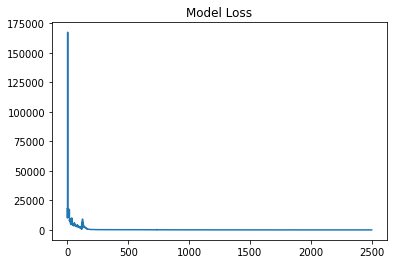

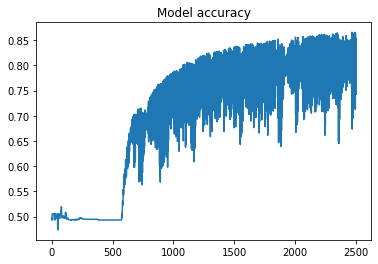

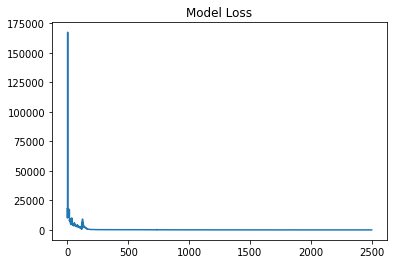

In [ ]:
h = history

plt.plot(acc_val)
plt.plot(acc_test)
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.plot(loss_val)
plt.title('Model Loss')
plt.show()

plt.plot(h.history['acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.title('Model Loss')
plt.show()

# Converting LAB to RGB for the predicted Images

> Indented block



In [ ]:
def get_LAB(image_l, image_ab):
       
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
 
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb
def get_LAB1(image_l):
    image_ab =  np.ones((224,224,2))*128
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
 
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb

# Resulting Images 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



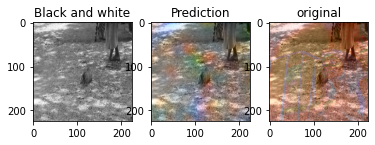

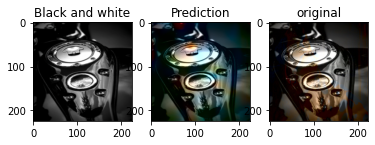

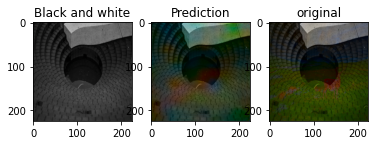

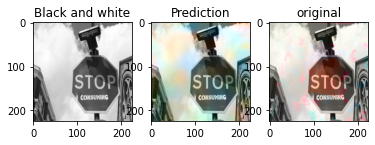

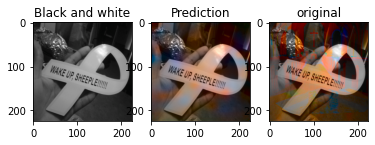

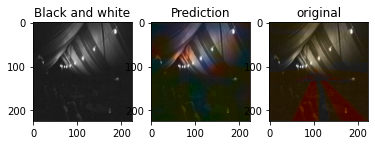

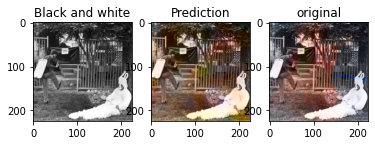

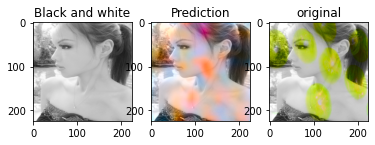

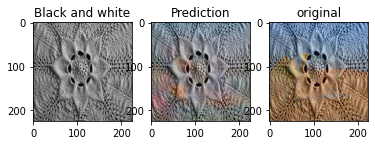

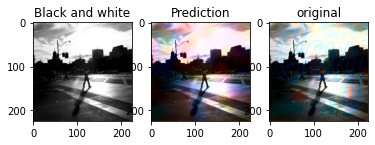

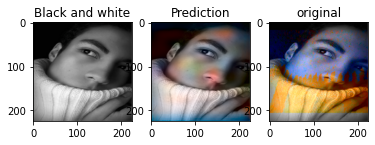

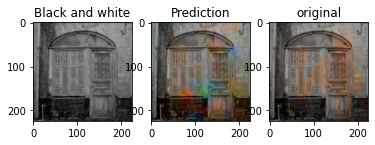

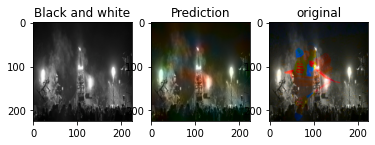

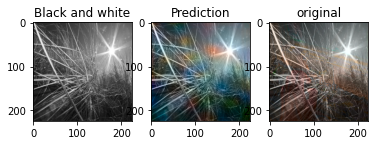

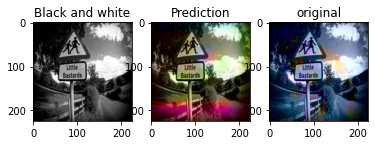

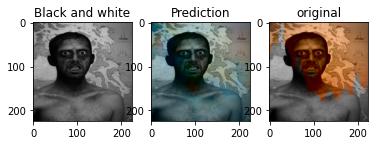

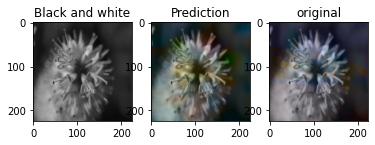

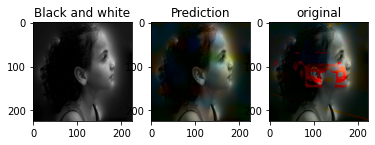

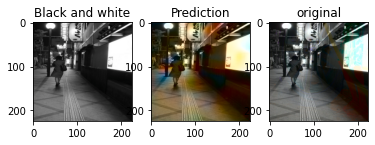

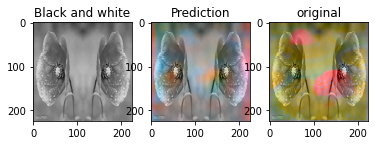

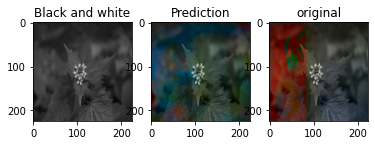

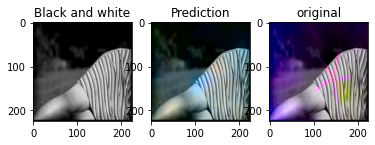

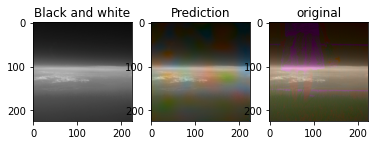

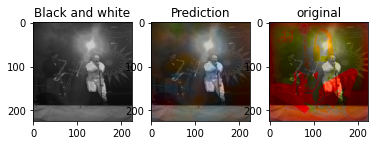

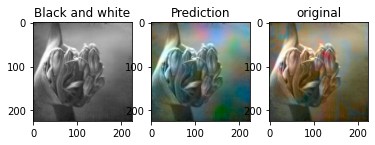

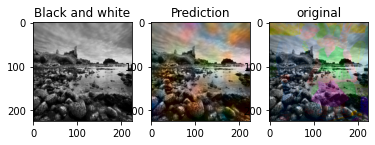

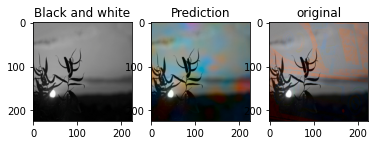

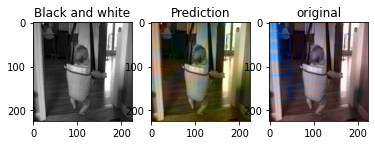

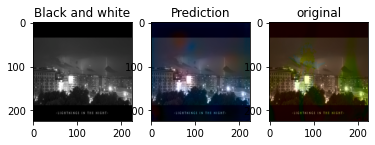

In [ ]:
for i in range(1, 30):
    pred = get_LAB(X_val[i], output[i])
    real = get_LAB(X_val[i],y_test[i])
    original = get_LAB1(X_val[i])
    f, axarr = plt.subplots(1,3)
    axarr[0].title.set_text('Black and white')  
    axarr[1].title.set_text('Prediction')  
    axarr[2].title.set_text('original')  
    axarr[0].imshow(original)
    axarr[1].imshow(pred)
    axarr[2].imshow(real)